In [1]:
%matplotlib notebook

In [2]:
from torch import cat
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import torch

from mpl_toolkits.mplot3d import axes3d 
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from time import time

import sys
sys.path.append('..')
from RoughPaths import *
from RDEs import *
from ExamplePaths import *

## Optimal Asset Allocation:
From https://s3.amazonaws.com/rendezvouswithdestiny.me/finance/max_hjb_mean_var.html

Market with constant interest rate $r$ and risky asset $S_t$, such that

\begin{align*}
    dS_t = \mu S_t dt + \sigma S_t dB_t
\end{align*}
with $\mu = r + \xi \sigma$

Wealth process
\begin{align*}
    dW_t = p \frac{W_t}{S_t} dS_t + \pi dt + (1 - p) W_t r dt
\end{align*}
with $p = p_t$ adapted and continuous percentage of wealth in the risky asset.

Then
\begin{align*}
    dW_t = [(r + p \xi \sigma) W_t + \pi] dt + p \sigma W_t dB_t.
\end{align*}

Goal: Maximize $\mathbb E [W_T]$ while minimizing $Var [W_T]$.

$\Rightarrow$ Maximize $L(W_T) = \mathbb E [W_T] - \lambda Var [W_T]$.

#### Ansatz:
$p_t = p(t, W_t)$ with a continuous function $p$. Set of Parameters:

In [3]:
r     = 0.03
sigma = 0.15
xi    = 0.33
pi    = 0.1
W0    = 1.0
T     = 20.0

lamb = .5
batch_size = 1000

In [4]:
NN = nn.Sequential(nn.Linear(2, 5), nn.LeakyReLU(), nn.Linear(5, 5), nn.LeakyReLU(), nn.Linear(5, 1), nn.Sigmoid())

def p(W, t):
    if len(t.shape) < 1:
        t = t.view(1, 1)
    if t.shape[0] == 1:
        t = t.view(1, 1)
        t = t.repeat(batch_size, 1)
    W = W.view(batch_size, 1)
    v = cat([t, W], dim=1)
    return NN(v)

def mu(W, t):
    return (r + xi * sigma * p(W, t)) * W + pi

def f(W, t):
    return (sigma * p(W, t) * W).view(batch_size, 1, 1)

In [5]:
path = ItoBrownianRoughPath(1, batch_size)
optim = Adam(NN.parameters())

epochs = 1000
start_time = time()
for i in range(epochs):
    path.reset()
    optim.zero_grad()
    sol = RDESolution(mu, f, 1, path, f_prime="difference_quotient", starting_point=W0, delta_t_max=0.01)
    W_T = sol(T)
    loss = - W_T.mean(dim=0) + lamb * W_T.var(dim=0, unbiased=True)
    loss.backward()
    optim.step()
    print(f"epoch {i+1}:\tgoal_value={-loss.item():.5f}\tmean={W_T.mean().item():.5f}\tin {(time() - start_time)/(i+1):.1f} s/epoch\ttime remaining: {(time() - start_time)/(i+1)*(epochs - i - 1):.1f}s")

epoch 1:	goal_value=5.02219	mean=6.56862	in 3.6 s/epoch	time remaining: 3626.7s
epoch 2:	goal_value=5.10179	mean=6.61323	in 3.6 s/epoch	time remaining: 3641.4s
epoch 3:	goal_value=5.15850	mean=6.58266	in 3.7 s/epoch	time remaining: 3706.4s
epoch 4:	goal_value=4.94847	mean=6.56381	in 3.8 s/epoch	time remaining: 3744.7s
epoch 5:	goal_value=4.92757	mean=6.51386	in 3.8 s/epoch	time remaining: 3739.7s
epoch 6:	goal_value=5.06887	mean=6.48558	in 3.8 s/epoch	time remaining: 3748.8s
epoch 7:	goal_value=5.07449	mean=6.44710	in 3.8 s/epoch	time remaining: 3763.5s
epoch 8:	goal_value=5.08240	mean=6.48032	in 3.8 s/epoch	time remaining: 3769.3s
epoch 9:	goal_value=5.07909	mean=6.50081	in 3.8 s/epoch	time remaining: 3774.7s
epoch 10:	goal_value=5.19757	mean=6.58124	in 3.8 s/epoch	time remaining: 3770.6s
epoch 11:	goal_value=5.20862	mean=6.58521	in 3.8 s/epoch	time remaining: 3774.0s
epoch 12:	goal_value=5.20469	mean=6.50310	in 3.8 s/epoch	time remaining: 3762.7s
epoch 13:	goal_value=5.16646	mean=6.6

epoch 103:	goal_value=5.27441	mean=6.36374	in 3.9 s/epoch	time remaining: 3471.2s
epoch 104:	goal_value=5.31009	mean=6.41207	in 3.9 s/epoch	time remaining: 3468.0s
epoch 105:	goal_value=5.43771	mean=6.47805	in 3.9 s/epoch	time remaining: 3464.8s
epoch 106:	goal_value=5.41578	mean=6.44452	in 3.9 s/epoch	time remaining: 3461.3s
epoch 107:	goal_value=5.47881	mean=6.51972	in 3.9 s/epoch	time remaining: 3458.6s
epoch 108:	goal_value=5.44766	mean=6.36483	in 3.9 s/epoch	time remaining: 3454.8s
epoch 109:	goal_value=5.43288	mean=6.49023	in 3.9 s/epoch	time remaining: 3451.4s
epoch 110:	goal_value=5.40394	mean=6.40951	in 3.9 s/epoch	time remaining: 3447.5s
epoch 111:	goal_value=5.50504	mean=6.44426	in 3.9 s/epoch	time remaining: 3443.5s
epoch 112:	goal_value=5.36724	mean=6.49542	in 3.9 s/epoch	time remaining: 3440.6s
epoch 113:	goal_value=5.46405	mean=6.45475	in 3.9 s/epoch	time remaining: 3436.5s
epoch 114:	goal_value=5.48275	mean=6.47231	in 3.9 s/epoch	time remaining: 3432.7s
epoch 115:	goal_

epoch 203:	goal_value=5.63900	mean=6.55733	in 3.9 s/epoch	time remaining: 3090.9s
epoch 204:	goal_value=5.70434	mean=6.59997	in 3.9 s/epoch	time remaining: 3087.3s
epoch 205:	goal_value=5.75213	mean=6.59192	in 3.9 s/epoch	time remaining: 3083.9s
epoch 206:	goal_value=5.50401	mean=6.46187	in 3.9 s/epoch	time remaining: 3080.0s
epoch 207:	goal_value=5.54010	mean=6.52557	in 3.9 s/epoch	time remaining: 3076.3s
epoch 208:	goal_value=5.56954	mean=6.53314	in 3.9 s/epoch	time remaining: 3072.2s
epoch 209:	goal_value=5.68904	mean=6.55435	in 3.9 s/epoch	time remaining: 3068.3s
epoch 210:	goal_value=5.59591	mean=6.52331	in 3.9 s/epoch	time remaining: 3064.3s
epoch 211:	goal_value=5.65422	mean=6.49687	in 3.9 s/epoch	time remaining: 3060.3s
epoch 212:	goal_value=5.52973	mean=6.45619	in 3.9 s/epoch	time remaining: 3056.4s
epoch 213:	goal_value=5.76554	mean=6.55604	in 3.9 s/epoch	time remaining: 3052.7s
epoch 214:	goal_value=5.71528	mean=6.55394	in 3.9 s/epoch	time remaining: 3049.1s
epoch 215:	goal_

epoch 303:	goal_value=5.84647	mean=6.67901	in 3.8 s/epoch	time remaining: 2671.1s
epoch 304:	goal_value=5.85468	mean=6.71669	in 3.8 s/epoch	time remaining: 2666.9s
epoch 305:	goal_value=5.94312	mean=6.75505	in 3.8 s/epoch	time remaining: 2662.7s
epoch 306:	goal_value=5.88248	mean=6.71154	in 3.8 s/epoch	time remaining: 2658.4s
epoch 307:	goal_value=5.84175	mean=6.68491	in 3.8 s/epoch	time remaining: 2654.3s
epoch 308:	goal_value=5.80718	mean=6.66393	in 3.8 s/epoch	time remaining: 2650.2s
epoch 309:	goal_value=5.82454	mean=6.65346	in 3.8 s/epoch	time remaining: 2646.0s
epoch 310:	goal_value=5.83712	mean=6.67547	in 3.8 s/epoch	time remaining: 2641.9s
epoch 311:	goal_value=5.87157	mean=6.69972	in 3.8 s/epoch	time remaining: 2637.8s
epoch 312:	goal_value=5.77398	mean=6.62677	in 3.8 s/epoch	time remaining: 2634.0s
epoch 313:	goal_value=5.78677	mean=6.66773	in 3.8 s/epoch	time remaining: 2629.8s
epoch 314:	goal_value=5.95913	mean=6.71061	in 3.8 s/epoch	time remaining: 2625.8s
epoch 315:	goal_

epoch 403:	goal_value=5.95989	mean=6.72984	in 3.8 s/epoch	time remaining: 2269.1s
epoch 404:	goal_value=5.98699	mean=6.74009	in 3.8 s/epoch	time remaining: 2265.1s
epoch 405:	goal_value=5.94495	mean=6.76693	in 3.8 s/epoch	time remaining: 2261.2s
epoch 406:	goal_value=6.03097	mean=6.81632	in 3.8 s/epoch	time remaining: 2257.3s
epoch 407:	goal_value=6.06176	mean=6.84947	in 3.8 s/epoch	time remaining: 2253.4s
epoch 408:	goal_value=5.98929	mean=6.82429	in 3.8 s/epoch	time remaining: 2249.4s
epoch 409:	goal_value=5.79572	mean=6.74290	in 3.8 s/epoch	time remaining: 2245.5s
epoch 410:	goal_value=5.93906	mean=6.81860	in 3.8 s/epoch	time remaining: 2241.6s
epoch 411:	goal_value=5.82750	mean=6.77356	in 3.8 s/epoch	time remaining: 2237.7s
epoch 412:	goal_value=5.88263	mean=6.77717	in 3.8 s/epoch	time remaining: 2234.0s
epoch 413:	goal_value=6.05662	mean=6.81018	in 3.8 s/epoch	time remaining: 2230.3s
epoch 414:	goal_value=5.92464	mean=6.76902	in 3.8 s/epoch	time remaining: 2226.4s
epoch 415:	goal_

epoch 503:	goal_value=6.03320	mean=6.79308	in 3.8 s/epoch	time remaining: 1878.9s
epoch 504:	goal_value=6.00089	mean=6.79365	in 3.8 s/epoch	time remaining: 1875.0s
epoch 505:	goal_value=5.92784	mean=6.74142	in 3.8 s/epoch	time remaining: 1871.1s
epoch 506:	goal_value=6.07143	mean=6.82108	in 3.8 s/epoch	time remaining: 1867.3s
epoch 507:	goal_value=6.11191	mean=6.81665	in 3.8 s/epoch	time remaining: 1863.4s
epoch 508:	goal_value=6.07241	mean=6.81059	in 3.8 s/epoch	time remaining: 1859.5s
epoch 509:	goal_value=5.89298	mean=6.75485	in 3.8 s/epoch	time remaining: 1855.6s
epoch 510:	goal_value=6.05636	mean=6.84636	in 3.8 s/epoch	time remaining: 1851.7s
epoch 511:	goal_value=5.91612	mean=6.78267	in 3.8 s/epoch	time remaining: 1847.9s
epoch 512:	goal_value=6.10986	mean=6.85313	in 3.8 s/epoch	time remaining: 1843.9s
epoch 513:	goal_value=6.00882	mean=6.83322	in 3.8 s/epoch	time remaining: 1840.1s
epoch 514:	goal_value=5.96678	mean=6.83443	in 3.8 s/epoch	time remaining: 1836.3s
epoch 515:	goal_

epoch 603:	goal_value=6.00598	mean=6.81672	in 3.8 s/epoch	time remaining: 1492.8s
epoch 604:	goal_value=5.95229	mean=6.80224	in 3.8 s/epoch	time remaining: 1489.0s
epoch 605:	goal_value=6.30130	mean=6.95748	in 3.8 s/epoch	time remaining: 1485.1s
epoch 606:	goal_value=5.93901	mean=6.78291	in 3.8 s/epoch	time remaining: 1481.3s
epoch 607:	goal_value=5.95500	mean=6.80406	in 3.8 s/epoch	time remaining: 1477.5s
epoch 608:	goal_value=6.06978	mean=6.84126	in 3.8 s/epoch	time remaining: 1473.6s
epoch 609:	goal_value=5.91800	mean=6.77546	in 3.8 s/epoch	time remaining: 1469.8s
epoch 610:	goal_value=5.99347	mean=6.82235	in 3.8 s/epoch	time remaining: 1466.0s
epoch 611:	goal_value=6.10050	mean=6.85826	in 3.8 s/epoch	time remaining: 1462.1s
epoch 612:	goal_value=6.03919	mean=6.83975	in 3.8 s/epoch	time remaining: 1458.3s
epoch 613:	goal_value=5.91910	mean=6.77782	in 3.8 s/epoch	time remaining: 1454.5s
epoch 614:	goal_value=6.15485	mean=6.89149	in 3.8 s/epoch	time remaining: 1450.6s
epoch 615:	goal_

epoch 703:	goal_value=5.95459	mean=6.82677	in 3.7 s/epoch	time remaining: 1112.4s
epoch 704:	goal_value=6.07565	mean=6.85541	in 3.7 s/epoch	time remaining: 1108.7s
epoch 705:	goal_value=6.05708	mean=6.85724	in 3.7 s/epoch	time remaining: 1104.9s
epoch 706:	goal_value=6.25706	mean=6.94710	in 3.7 s/epoch	time remaining: 1101.1s
epoch 707:	goal_value=6.13275	mean=6.89053	in 3.7 s/epoch	time remaining: 1097.3s
epoch 708:	goal_value=6.07466	mean=6.86004	in 3.7 s/epoch	time remaining: 1093.5s
epoch 709:	goal_value=6.10848	mean=6.88815	in 3.7 s/epoch	time remaining: 1089.7s
epoch 710:	goal_value=5.98140	mean=6.84741	in 3.7 s/epoch	time remaining: 1086.0s
epoch 711:	goal_value=6.14872	mean=6.93256	in 3.7 s/epoch	time remaining: 1082.2s
epoch 712:	goal_value=5.92178	mean=6.84212	in 3.7 s/epoch	time remaining: 1078.4s
epoch 713:	goal_value=6.10858	mean=6.90304	in 3.7 s/epoch	time remaining: 1074.6s
epoch 714:	goal_value=5.96136	mean=6.84893	in 3.7 s/epoch	time remaining: 1070.8s
epoch 715:	goal_

epoch 804:	goal_value=6.00386	mean=6.84306	in 3.7 s/epoch	time remaining: 732.0s
epoch 805:	goal_value=5.98599	mean=6.83410	in 3.7 s/epoch	time remaining: 728.3s
epoch 806:	goal_value=5.92674	mean=6.78559	in 3.7 s/epoch	time remaining: 724.5s
epoch 807:	goal_value=6.05339	mean=6.81972	in 3.7 s/epoch	time remaining: 720.8s
epoch 808:	goal_value=5.93581	mean=6.78593	in 3.7 s/epoch	time remaining: 717.0s
epoch 809:	goal_value=6.08803	mean=6.82777	in 3.7 s/epoch	time remaining: 713.3s
epoch 810:	goal_value=5.99517	mean=6.80791	in 3.7 s/epoch	time remaining: 709.5s
epoch 811:	goal_value=6.19990	mean=6.90050	in 3.7 s/epoch	time remaining: 705.7s
epoch 812:	goal_value=6.01380	mean=6.81898	in 3.7 s/epoch	time remaining: 702.0s
epoch 813:	goal_value=6.08075	mean=6.86778	in 3.7 s/epoch	time remaining: 698.2s
epoch 814:	goal_value=6.14214	mean=6.89032	in 3.7 s/epoch	time remaining: 694.5s
epoch 815:	goal_value=5.92581	mean=6.81495	in 3.7 s/epoch	time remaining: 690.8s
epoch 816:	goal_value=6.0066

epoch 906:	goal_value=5.97166	mean=6.82000	in 3.7 s/epoch	time remaining: 350.7s
epoch 907:	goal_value=5.86105	mean=6.78674	in 3.7 s/epoch	time remaining: 346.9s
epoch 908:	goal_value=5.97958	mean=6.83459	in 3.7 s/epoch	time remaining: 343.2s
epoch 909:	goal_value=5.98218	mean=6.82832	in 3.7 s/epoch	time remaining: 339.5s
epoch 910:	goal_value=6.01805	mean=6.83212	in 3.7 s/epoch	time remaining: 335.7s
epoch 911:	goal_value=6.06599	mean=6.84898	in 3.7 s/epoch	time remaining: 332.0s
epoch 912:	goal_value=5.94504	mean=6.76967	in 3.7 s/epoch	time remaining: 328.3s
epoch 913:	goal_value=6.02074	mean=6.82911	in 3.7 s/epoch	time remaining: 324.5s
epoch 914:	goal_value=6.04658	mean=6.78153	in 3.7 s/epoch	time remaining: 320.8s
epoch 915:	goal_value=6.14492	mean=6.85523	in 3.7 s/epoch	time remaining: 317.1s
epoch 916:	goal_value=6.07046	mean=6.83351	in 3.7 s/epoch	time remaining: 313.3s
epoch 917:	goal_value=5.95091	mean=6.79116	in 3.7 s/epoch	time remaining: 309.6s
epoch 918:	goal_value=5.9330

<IPython.core.display.Javascript object>


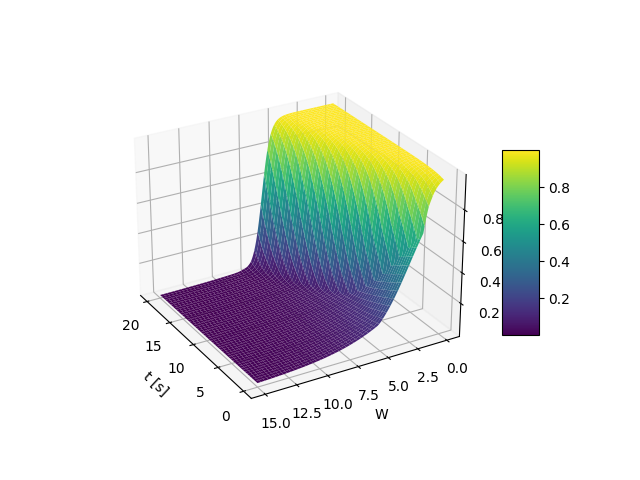

In [8]:
N = 100
Wmax = 15

batch_size = 1
ts = np.linspace(0, T, N)
Ws = np.linspace(0, Wmax, N)
ts, Ws = np.meshgrid(ts, Ws)
Zs = np.array([[p(tensor(Ws[i][j], dtype=torch.float).view(1, 1), tensor(ts[i][j], dtype=torch.float)).item() for j in range(N)] for i in range(N)])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(ts, Ws, Zs, cmap='viridis', edgecolor='none')
ax.set_xlabel('t [s]')
ax.set_ylabel('W')
ax.set_zlabel('p')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

The constant strategy $p = 0$ gives
\begin{align*}
    dW_t = (\pi + r W_t) dt
\end{align*}

With the solution
\begin{align*}
    W_t = \left(W_0 + \frac{\pi}{r} \right) e^{r t} - \frac{\pi}{r}.
\end{align*}
Therefore
\begin{align*}
    W_{20} = \left(1 + \frac{0.1}{0.03} \right) e^{0.03 \cdot 20} - \frac{0.1}{0.03} \approx 4.56
\end{align*}